# 2CS-SIL2/SIQ2 Lab02. Regularization and Feature selection

<p style='text-align: right;font-style: italic;'>Designed by: Abdelkrime Aries</p>

In this lab, we will learn about:
- Regularization
- Feature selection

**Team:**
- **Member 01**: Zaineb BOUKHETALA
- **Member 02**: Amira HADDAD
- **Group**: SQ2

In [ ]:
import sys, timeit
import datetime
from typing          import Tuple, List, Type
from collections.abc import Callable

sys.version

'3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]'

In [ ]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.26.4', '2.2.2', '3.10.0')

In [ ]:
import sklearn

from sklearn.metrics           import f1_score
from sklearn.linear_model      import LogisticRegression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SequentialFeatureSelector


sklearn.__version__

'1.6.1'

In [ ]:
# This code is used to filter warnings concerning convergence
# In general, when the maximum number of iterations is not suffisant to converge
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [ ]:
# Logistic regression code
# Do not modify this code, or earth will eat itself

# Weighted sum
def zf(X: np.ndarray, theta: np.ndarray) -> np.ndarray:
    return X @ theta

# Sigmoid function
def sg(Z: np.ndarray) -> np.ndarray:
    return  1 / (1 + np.exp(-Z))

# Probability estimation
def hf(X: np.ndarray, theta: np.ndarray) -> np.ndarray:
    return sg(zf(X, theta))

# Loss function
def BCE(Y: np.ndarray, H: np.ndarray, e: float=1e-8) -> float:
    return - np.mean(Y * np.log(H + e) + (1-Y) * np.log(1-H + e))

# Gradients
def dBCE(X: np.ndarray, Y: np.ndarray, H: np.ndarray) -> np.ndarray:
    return  np.dot(X.T, H-Y)/X.shape[0]

# Parameters update
def update(Theta: np.ndarray, Gradient: np.ndarray, alpha: np.ndarray) -> np.ndarray:
    return Theta - alpha * Gradient

# Normalization
def normalize(X: np.ndarray, mean: np.ndarray=None, std: np.ndarray=None) -> np.ndarray:
    if (mean is None) or (std is None):
        mean = np.mean(X, axis=0)
        std  = np.std(X, axis=0)
    X_norm = np.where(std==0, X, (X - mean)/std)
    return X_norm, mean, std


def prepare(X: np.ndarray, norm: np.ndarray=True,
             const: np.ndarray=True, mean: np.ndarray=None, std: np.ndarray=None) -> np.ndarray:
    X_pre = X.copy()
    if norm:
        X_pre, mean, std = normalize(X_pre,mean=mean, std=std)
    if const:
        X_pre = np.append(np.ones((X_pre.shape[0],1)), X_pre ,axis=1)
    return X_pre, mean, std

def generate_zeros_1(nbr: int) -> np.ndarray:
    return np.zeros(nbr)

def generate_ones_1(nbr: int) -> np.ndarray:
    return np.ones(nbr)

print('DONE')

DONE


## I. Algorithms implementation

In this section, we will try to implement some regularization functions as well as a filtering one.
Regularization will be applied on logistic regression.

### I.1.  L2 penalty

L2 penalty + Linear regression = Ridge regression.

#### I.2.1. L2 cost function

**L2** cost function is calculated as:

$$J_{L2}(\theta) = \frac{\lambda }{2M} \sum\limits_{j=1}^{N} \theta_j^2$$

- **M**: number of samples
- **N**: number of features


**Note** In some references, this regularization is not divided by $M$. In practice, it must be normalized over $M$. [This is an answer on stackexchange](https://stats.stackexchange.com/questions/287920/regularisation-why-multiply-by-1-2m) explaining why. A side information: for one sample, we call it 'loss function', for a batch it is called 'cost function'.

In [ ]:
# TODO: L2 cost function
def J_L2(Theta: np.ndarray, M: int, Lambda: float=0.) -> float:
    J =Lambda * np.sum(Theta[1:]**2) / (2*M)
    return J

# The first element is the bias,
# thus it must not be included in the cost
Theta_t = np.array([1, 0.01, 0.1])


J_L2(Theta_t, 4), J_L2(Theta_t, 4, Lambda=.4)

(0.0, 0.0005050000000000001)

#### 1.2.2. L2 gradient function

**L2** gradient function is given as:

$$\frac{\partial J_{L2}(\theta)}{\partial \theta_j} = \frac{\lambda }{M} \theta_j \text{ if } j > 0$$

$$\frac{\partial J_{L2}(\theta)}{\partial \theta_0} = 0$$

- **M**: number of samples
- **N**: number of features


In [ ]:
# TODO: L2 gradient function
def dJ_L2(Theta: np.ndarray, M: int, Lambda: float=0.) -> np.ndarray:
    Theta_copy = np.copy(Theta)
    Theta_copy[0]=0
    return  (Lambda/M) * Theta_copy

# The first element is the bias,
# thus it must always have a gradient of 0
Theta_t = np.array([1, 0.01, 0.1])

dJ_L2(Theta_t, 4), dJ_L2(Theta_t, 4, Lambda=0.4)

(array([0., 0., 0.]), array([0.   , 0.001, 0.01 ]))

### I.2.  L1 penalty

L1 penalty + Linear regression = Lasso regression.

#### I.2.1. L2 cost function

**L1** cost function is calculated as:

$$J_{L1}(\theta) = \frac{\lambda}{M} \sum\limits_{j=1}^{N} |\theta_j|$$

- **M**: number of samples
- **N**: number of features

In [ ]:
# TODO: L1 cost function
def J_L1(Theta: np.ndarray, M: int, Lambda: float=0.) -> float:
    return Lambda * np.sum(np.abs(Theta[1:])) / M

# The first element is the bias,
# thus it must not be included in the cost
Theta_t = np.array([1, 0.01, 0.1])

J_L1(Theta_t, 4), J_L1(Theta_t, 4, Lambda=.4)

(0.0, 0.011000000000000001)

#### I.2.2. Soft-Thresholding

$L1$ derivative is:
$$\frac{\partial L1}{\partial \theta_j} = \frac{\partial \frac{\lambda }{M} \sum\limits_{j=1}^{N} |\theta_j|}{\partial \theta_j} = \frac{\lambda }{M} \frac{\theta_j}{|\theta_j|}$$

It is clear that the gradient is not defined when $\theta_j = 0$.
Applying [Subderivative](https://en.wikipedia.org/wiki/Subderivative), we'll get:
$$
\frac{\partial L1}{\partial \theta_j} =
\begin{cases}
-\frac{\lambda}{M} & \text{if } \theta_j < 0 \\
0 & \text{si } \theta_j = 0 \\
\frac{\lambda}{M} & \text{if } \theta_j > 0 \\
\end{cases}
$$

Nous ne pouvons pas utiliser la descente du gradient pour résoudre ça.
Nous allons utiliser un algorithme de descente du gradient approximative, qui s'appelle **Iterative soft-thresholding algorithm (ISTA)**.
$$prox(\theta) = S_{\lambda}(\theta) =
\begin{cases}
\theta_j + \lambda & \text{si } \theta_j < - \lambda \\
0 & \text{si } -\lambda \le \theta_j \le \lambda \\
\theta_j - \lambda & \text{si } \theta_j > \lambda \\
\end{cases}
$$

**Vous devez implémenter cette fonction**

Les thétas sont mises à jour comme suite :
$$ \theta = S_{\lambda}(\theta - \frac{\partial J_0}{\partial \theta})$$
Où, $J_0$ est la fonction du coût sans régularisation

Source : [Ryan Tibshirani (2015), Lecture 08: Proximal Gradient Descent](https://www.stat.cmu.edu/~ryantibs/convexopt-S15/scribes/08-prox-grad-scribed.pdf)

In [ ]:
# TODO: Soft-thresholding = prox(theta)
def S(Theta: np.ndarray, Lambda: float) -> np.ndarray:
    Theta_new = np.copy(Theta)
    Theta_new[1:] = np.where(Theta[1:] < -Lambda, Theta[1:] + Lambda,
                             np.where(Theta[1:] > Lambda, Theta[1:] - Lambda, 0))
    return Theta_new

# The first element is the bias,
# thus it must not be changed by soft-thresholding
Theta_t = np.array([0.5, -0.25, 0.05])

S(Theta_t, 0.1)

array([ 0.5 , -0.15,  0.  ])

### I.3. Regularized logistic regression

**>> Nothing to code here**

In [ ]:
# これをいじると舌が青くなるよ
# This can be gradient descent or ISTA based on the approx function
def optimize(X: np.ndarray, Y: np.ndarray, Theta: np.ndarray, approx: Callable=None, it_max: int=100, alpha: float=0.1, Lambda: float=0.):

    M = len(Y)

    if approx :
        def maj(Theta, J, dJ):
            J    += J_L1(Theta, M, Lambda=Lambda)
            Theta = update(Theta, dJ, alpha)
            Theta = S(Theta, Lambda/M) # Lamdba is normalized by th number of samples before applying S
            return J, Theta
    else:
        def maj(Theta, J, dJ):
            J    += J_L2(Theta, M, Lambda=Lambda)
            dJ   += dJ_L2(Theta, M, Lambda=Lambda)
            Theta = update(Theta, dJ, alpha)
            return J, Theta

    cost_history  = []
    Theta_history = []

    # we use a copy so that the input stays intact
    Theta  = Theta.copy()

    # here, we iterate till the last breath
    for it in range(it_max):
        H        = hf(X, Theta)
        J        = BCE(Y, H)
        dJ       = dBCE(X, Y, H)
        J, Theta = maj(Theta, J, dJ)
        cost_history.append(J)
        Theta_history.append(Theta.copy())

    return Theta_history, cost_history


X_t = np.array([
    [1, 1, 0.2],
    [1, 2, 0.1],
    [1, 3, 0.4],
    [1, 4, 0.3]
])

Theta_t = np.array([1., 1., 1.])
Y_t     = np.array([1, 0, 1, 0])

# No regularization: Lambda = 0
Theta_P, J_P = optimize(X_t, Y_t, Theta_t)
# L1 optimization: approximation with lambda
Theta_1, J_1 = optimize(X_t, Y_t, Theta_t, approx=S, Lambda=0.1)
# L2 optimization: lambda without approximation
Theta_2, J_2 = optimize(X_t, Y_t, Theta_t, Lambda=0.1)

Theta_P[-1], Theta_1[-1], Theta_2[-1]

(array([ 0.94839532, -0.56840255,  1.2813832 ]),
 array([ 0.46328109, -0.15750488,  0.        ]),
 array([ 0.93431089, -0.53451115,  1.03711393]))

In [ ]:
# Do not modify this
# if you do, you'll get a Vin Diesel head
class RegLogReg(object): # Regularized Logistic Regression

    # By default: no regularization :'(
    def __init__(self, it_max: int=100,
                 alpha: float=.01, Lambda: float=1.0, norm: bool=True, const: bool=True, reg: str=None):
        self.it_max = it_max
        self.alpha    = alpha
        self.norm     = norm
        self.const    = const
        self.approx   = None
        self.Lambda   = Lambda
        if reg == 'l1':
            self.approx = S
        elif reg != 'l2':
            self.Lambda = 0.

    def fit(self, X: np.ndarray, Y: np.ndarray):
        # we have to store mean and std to normalize when predicting
        X_pre, self.mean, self.std = prepare(X, norm=self.norm, const=self.const)
        Theta = generate_ones_1(X_pre.shape[1])
        self.Thetas, self.couts = optimize(X_pre, Y, Theta,
                                          approx=self.approx,
                                          it_max=self.it_max,
                                          alpha =self.alpha,
                                          Lambda=self.Lambda)

    # Prediction
    # if cls=True, the result is a vector of  1 and 0
    # otherwise, it will be a veector of probabilities
    def predict(self, X: np.ndarray, cls: bool=True, thrshold: float=0.5, it: int=-1) -> np.ndarray:
        X_pre, self.mean, self.std = prepare(X, norm=self.norm, const=self.const, mean=self.mean, std=self.std)
        H = hf(X_pre, self.Thetas[it])
        if cls:
            return (H >= thrshold).astype(int)
        return H

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (array([0.86383643, 0.5273866 , 0.96123235]),
#  array([0.79153709, 0.        , 0.        ]),
#  array([0.8515839 , 0.38351525, 0.7672672 ]),
#  array([0, 0, 1, 1]))
#---------------------------------------------------------------------

X_t = np.array([
    [100, 20],
    [200, 10],
    [300, 40],
    [400, 30]
])

Y_t = np.array([1, 0, 1, 0])

# No regularization
reglog = RegLogReg()
reglog.fit(X_t, Y_t)
# L1 regularization
reglog1 = RegLogReg(reg='l1')
reglog1.fit(X_t, Y_t)
# L2 regularization
reglog2 = RegLogReg(reg='l2')
reglog2.fit(X_t, Y_t)

reglog.Thetas[-1], reglog1.Thetas[-1], reglog2.Thetas[-1], reglog.predict(X_t)

(array([0.86383643, 0.5273866 , 0.96123235]),
 array([0.79241836, 0.        , 0.        ]),
 array([0.8515839 , 0.38351525, 0.7672672 ]),
 array([0, 0, 1, 1]))

### I.4. Filtering (ANOVA: Analysis of Variance)

For each class, there is a different number of samples.
This is why we will implemeent ANOVA for a CRD (COMPLETELY RANDOM DESIGN).
The algorithm is explained in [Richard Horsly (2012) COMPLETELY RANDOM DESIGN (CRD)](https://www.ndsu.edu/faculty/horsley/CRD.pdf).
To validate, we will use the example in page 10.

#### I.4.1. One way F value for one feature

Given a feature ($A$), its values are divided into $N$ sets, where $N$ is the number of classes.

$$CF = \frac{(\sum_{ij} A_{ij})^2}{\sum_j |A_j|} $$
Where $\sum_{ij} A_{ij}$ is the sum of all values of all classes,
$\sum_j |A_j|$ is the number of samples

$$ TotalSS = \sum_{ij} A_{ij}^2 - CF$$
Where $\sum_{ij} A_{ij}^2$ is the sum est les somme of values' squares

$$ TreatmentSS = \sum_j \frac{(\sum_{i} A_{ij})^2}{|A_j|} - CF$$
Where $\sum_{i} A_{ij}$ is the sum of all valus of class $j$ and $|A_j|$ is the number of samples in class $j$

$$ ErrorSS = TotalSS - TreatmentSS $$


In [ ]:
# TODO: One-way ANOVA for one feature
def f_oneway(A: np.ndarray) -> float:
    # 'A' is a list of N lists where N is the number of classes
    # These lists do not have the same size
    nbrs = np.array([len(a) for a in A]) # Number of samples in each class
    sums = np.array([np.sum(a) for a in A]) # Sum of values of each class
    ssum = np.sum([np.sum(np.array(a)**2) for a in A]) # Sum of all squared values

    # Complete here
    #====================================
    CF          = (np.sum(sums) ** 2) / np.sum(nbrs)
    TotalSS     = ssum - CF
    TreatmentSS = np.sum((sums ** 2) / nbrs) - CF
    ErrorSS     = TotalSS - TreatmentSS
    #====================================

    MSB = TreatmentSS / (len(A) - 1)
    MSW =  ErrorSS/(nbrs.sum() - len(A))
    return MSB/MSW


AA = [[2., 2.2, 1.8, 2.3, 1.7], [1.7, 1.9, 1.5], [2., 2.4, 2.7, 2.5, 2.4], [2.1, 2.2, 2.2, 1.9]]

f_oneway(AA)

6.418894830659841

#### I.4.2. One way F value for all feature

**>> Nothing to code here**

Here, we will calculate ANOVA F value for each feature.
Features with the highest F-value are the best.

In [ ]:
# Do not modify,
# If you do, your laptop will enslave you
def anova_f(X: np.ndarray, Y: np.ndarray) -> np.ndarray:

    C = np.unique(Y)
    F = []
    for j in range(X.shape[1]):
        A = X[:, j]
        F.append(f_oneway([A[Y==c] for c in np.unique(Y)]))
    return np.array(F)

X_t = np.array(
    [[2. , 1. , 1. ],
     [2.2, 2. , 1. ],
     [1.8, 3. , 1. ],
     [2.3, 4. , 1. ],
     [1.7, 5. , 2. ],
     [1.7, 1. , 2. ],
     [1.9, 2. , 2. ],
     [1.5, 3. , 2. ],
     [2. , 1. , 3. ],
     [2.4, 2. , 3. ],
     [2.7, 3. , 3. ],
     [2.5, 4. , 3. ],
     [2.4, 5. , 3. ],
     [2.1, 1. , 4. ],
     [2.2, 2. , 4. ],
     [2.2, 3. , 4. ],
     [1.9, 4. , 4. ]])

Y_t = np.array(['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D'])

# To validate, we will use scikit-learn's f_classif
# https://github.com/scikit-learn/scikit-learn/blob/95d4f0841d57e8b5f6b2a570312e9d832e69debc/sklearn/feature_selection/_univariate_selection.py#L42

f_sklearn, a = f_classif(X_t, Y_t)
f_notre      = anova_f  (X_t, Y_t)

# The first list is F-value of scikit-learn, the second is ours
f_sklearn, f_notre

(array([  6.41889483,   0.40595497, 105.2745098 ]),
 array([  6.41889483,   0.40595497, 105.2745098 ]))

## II. Application and Analysis

In this section, we will test different concepts by running an experiment, formulating a hypothesis and trying to justify it.
We will use the dataset [Diabetics prediction using logistic regression](https://www.kaggle.com/kandij/diabetes-dataset).

In [ ]:
diabetes   = pd.read_csv('data/diabetes2.csv')
X_diabetes = diabetes.iloc[:, :-1].values
Y_diabetes = diabetes.iloc[:,  -1].values

# This configuration is intended to be as such
# We want to test the case where logistic regression is disadvantaged
NBR_TEST = 240 # 30%
# Supposee the first NBR_TEST samples are used for test, the rest for train
X_test  = X_diabetes[-NBR_TEST:, :]
Y_test  = Y_diabetes[-NBR_TEST:   ]

X_train = X_diabetes[:-NBR_TEST, :]
Y_train = Y_diabetes[:-NBR_TEST   ]

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### II.1. Regularization

We trained 3 models:
- **lreg_00**: Logistic regression without regularization
- **lreg_l1**: Logistic regression with L1 regularization
- **lreg_l2**: Logistic regression with L2 regularization

To test these models, we will use the two datasets (with F1-score history):
- **train**: to evaluate models' fitting
- **test** : to evaluate models' generalization

To capture F1-score and paramteres history, we created models with only one iteration.
Then, we iterate outside "fit" function and call it each time.
To ensure that the model continues updating and not randomize parameters values, we activated the option **warm_start**.
In this case, the history graph will not as smooth as it should be.

**Note**: All parameters are initialized by 1, so we will exclude the possibility of a model having a favorable start point (near to the optimum).


In [ ]:
MAX_IT     = 500
CC         = 0.002

ITLST = list(range(MAX_IT))

# Initialize model's parameters to a predefined vector
def init_params(mdl: LogisticRegression, value:float=1., N=X_train.shape[1]):
    mdl.coef_      = np.array([[value] * N])
    mdl.intercept_ = np.array([value])

models = [
    ('00', LogisticRegression(penalty=None, solver='saga', max_iter=1, warm_start=True, random_state=0      )),
    ('L1', LogisticRegression(penalty='l1', solver='saga', max_iter=1, warm_start=True, random_state=0, C=CC)),
    ('L2', LogisticRegression(penalty='l2', solver='saga', max_iter=1, warm_start=True, random_state=0, C=CC))
]

history = {'Theta': {}, 'F1_train': {}, 'F1_test': {}}

for mdl_name, mdl in models:
    # Initialize all parameters to a shared start point
    init_params(mdl)
    history['Theta'   ][mdl_name] = []
    history['F1_test' ][mdl_name] = []
    history['F1_train'][mdl_name] = []


for it in ITLST:
    for mdl_name, mdl in models:
        mdl.fit(X_train, Y_train)
        coef = [mdl.intercept_[0]]
        coef.extend(mdl.coef_.flatten().tolist())
        history['Theta'][mdl_name].append(coef)
        history['F1_test'][mdl_name].append(f1_score(Y_test, mdl.predict(X_test)))
        history['F1_train'][mdl_name].append(f1_score(Y_train, mdl.predict(X_train)))

for mdl_name, mdl in models:
    history['Theta'][mdl_name] = np.array(history['Theta'][mdl_name])

# This is just to check the last time this was executed
# because the next cells depend on the results of this one
now = datetime.datetime.now()
print(now.strftime("%Y-%m-%d %H:%M:%S"))


2025-03-08 22:11:12


#### II.1.1.  Regularization and fitting/generalization

According to the train graph, we suppose a model has converged when it is in its highest F1-score peak.
For example, **Reg-L2** reached its highest F1-score around 150 iterations.
After that point, we want just to see what will happen if we keep training.

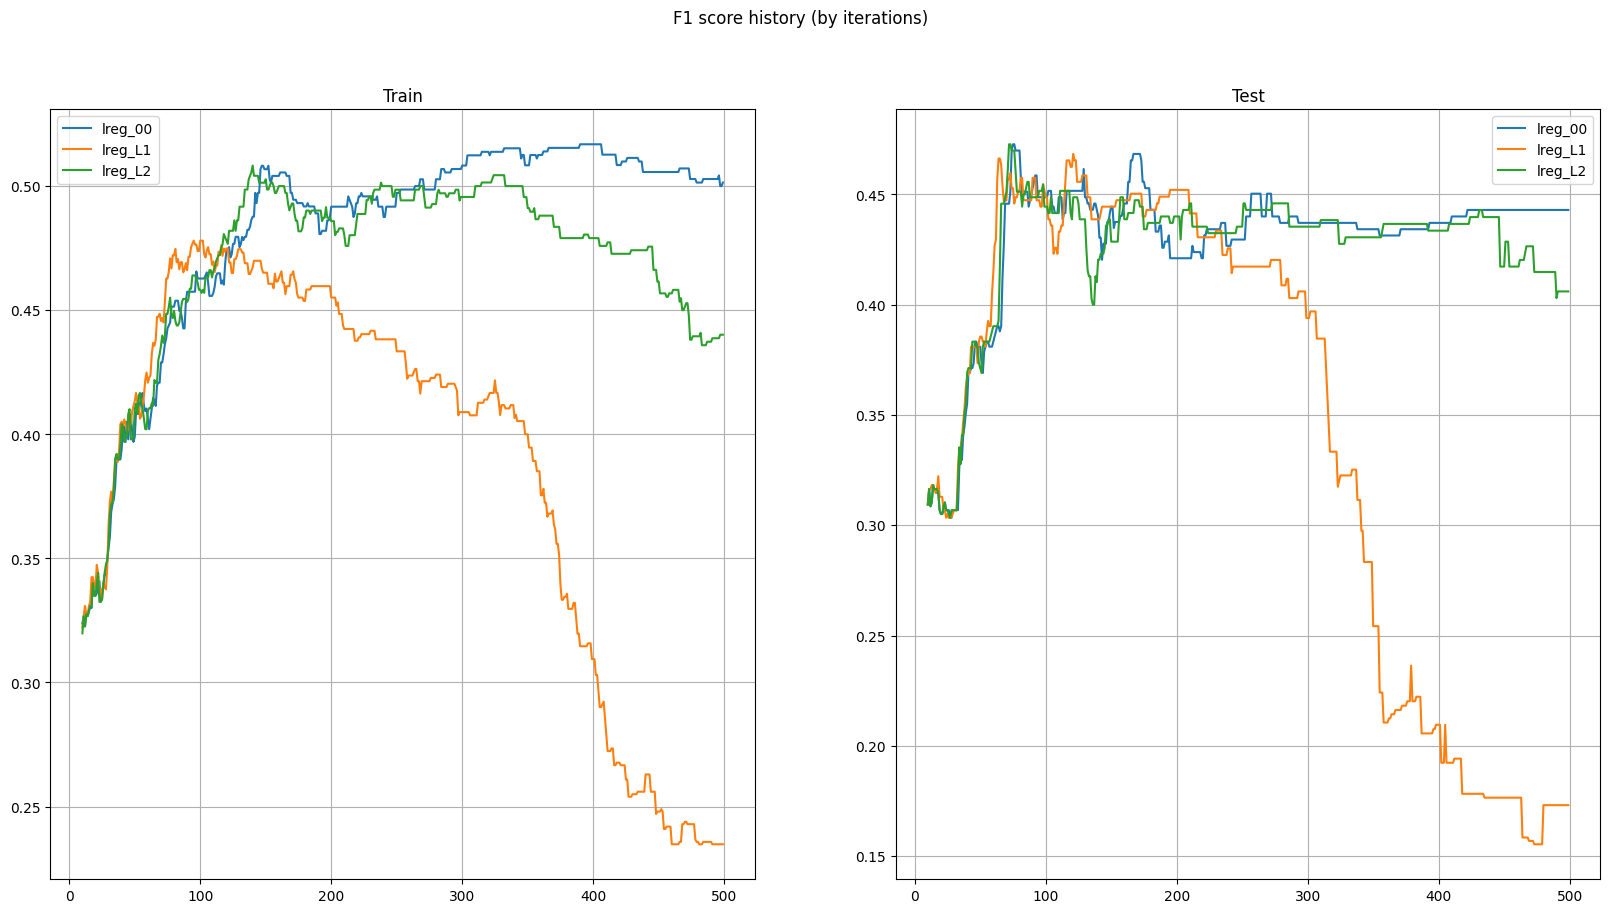

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('F1 score history (by iterations)')
fig.set_figwidth (20)
fig.set_figheight(10)


for mdl_name, mdl in models:
    ax1.plot(ITLST[10:], history['F1_train'][mdl_name][10:], label='lreg_' + mdl_name)
    ax2.plot(ITLST[10:], history['F1_test' ][mdl_name][10:], label='lreg_' + mdl_name)

ax1.legend()
ax2.legend()
ax1.set_title('Train')
ax2.set_title('Test')
ax1.grid()
ax2.grid()

plt.show()

**TODO: Analyze the results**

1. Analyze convergence (Train-graph): which model converges the fastest? with what price (what is the gain or loss)?
1. Explain why?
1. Based on that (nothing else), what is the benefit of regularization?
1. Why regularized models lose performance with much more iterations?
1. Based on that (nothing else), what is the limit of regularization?

**Answer**

1. Reg-L1 (Lasso) converges the fastest (around 100 iterations) but it degrades later, the F1-score is almost null by the 500th interation which means that the loss is high.
   Non regularized model performs the best on the training set (but we know it may overfit :) )
1. L1 does a sort of feature selection while converging quickly by setting some Thetas to zero. It peaks early, then collapses as important features may get removed, thats why we notice it performs badly on the training and testing set by the time it reaches 500 iterations, but L2 stabilizes weights which appeared to be good for our current dataset(MUCH better than L1 atleast).
1. prevent overfitting, making models generalize better on test data.
1. Regularized models lose performance with more iterations because the regularization term continues to penalize weights. like L1 forces many weights to zero, that makes us lose many useful features!! as we've seen in the graphs above,  as for l2 it may keep shriking weights and the model becomes hardly interpretable (because all weights become shrunk and nearly in the same weight so we literally learn no complex patterns if there are any!!)
1. Regularization can go too far in its thing that it can lose purpose. If l1 overdoes itself, it'll eliminate too many features. If L2 is execessive, itll shrink the weights too much. Either way, the model becomes too simple and misses important patterns in our data.

#### II.1.2. Regularization and parameters

Here, we will plot parameters history.

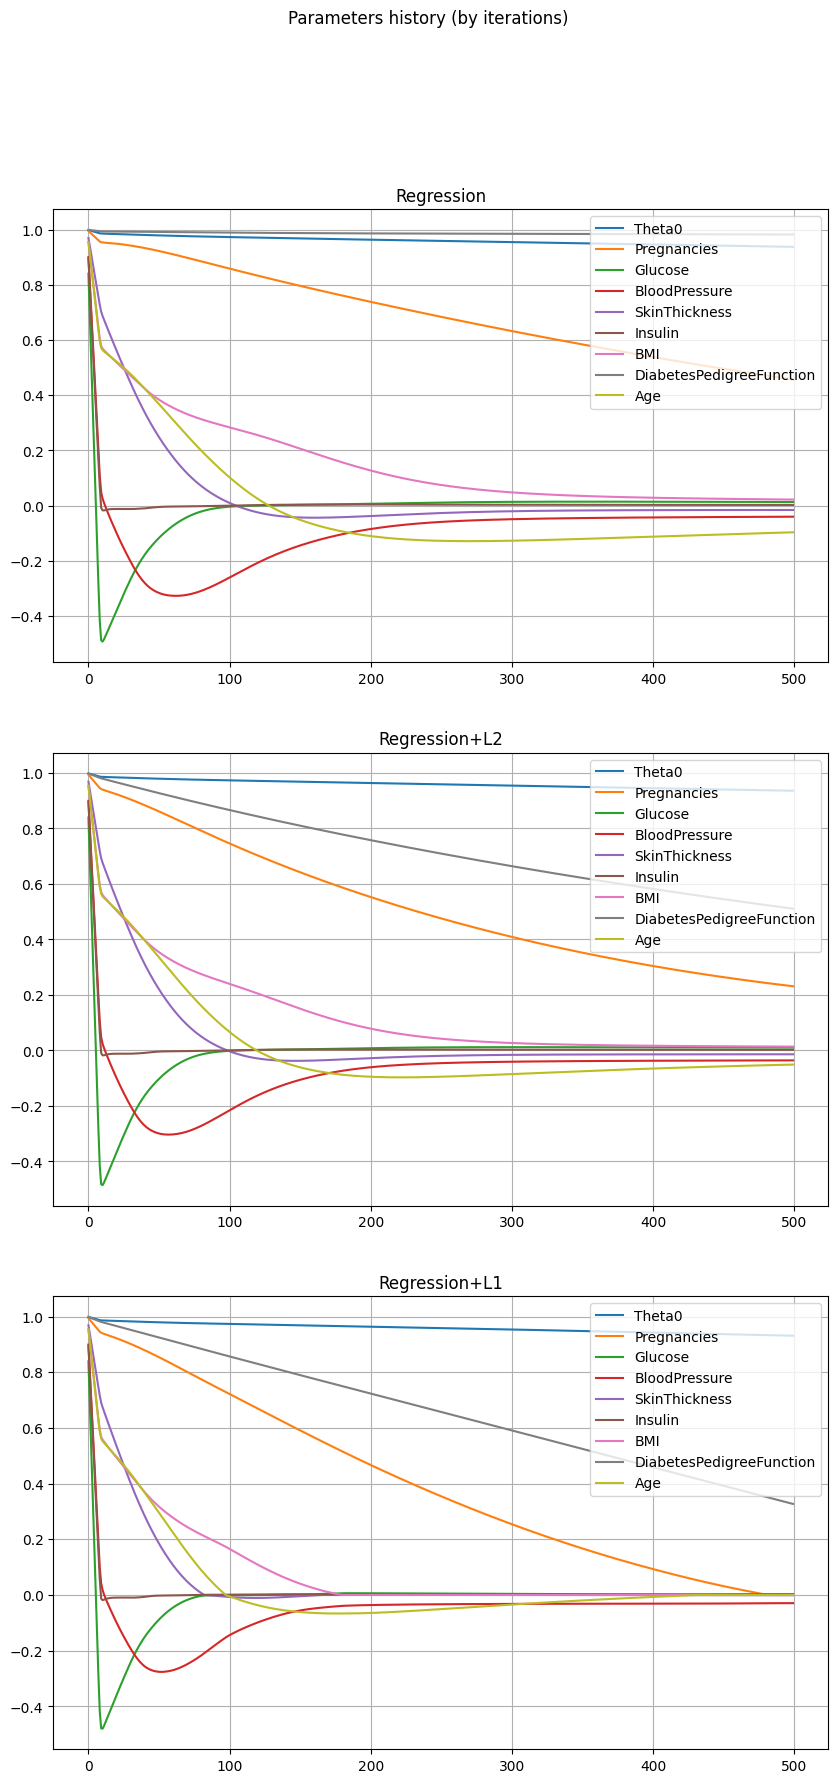

In [ ]:
labels = list(diabetes.columns)
labels.pop()
labels = ['Theta0'] + labels
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.suptitle('Parameters history (by iterations)')
fig.set_figwidth (10)
fig.set_figheight(20)
for i in range(len(labels)):
    ax1.plot(ITLST, history['Theta']['00'][:, i], label=labels[i])
    ax3.plot(ITLST, history['Theta']['L1'][:, i], label=labels[i])
    ax2.plot(ITLST, history['Theta']['L2'][:, i], label=labels[i])

ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_title('Regression')
ax2.set_title('Regression+L2')
ax3.set_title('Regression+L1')

ax1.grid()
ax2.grid()
ax3.grid()

plt.show()

**TODO: Analyze the results**

1. Why when we apply regularization, parameters tend to converge more into 0?
1. Why there are parameters which coverge faster than others?
1. Can we find the most important parameters using parameters history? If so, give the two most important ones. Otherwise, explain why.
1. Can we use regularization as feature selection? If so, precise how it can be seen as such. Otherwise, precise why. Discuss L1 and L2 separately.

**Answer**

1. Regularization penalize large parameter values, forcing them to shrink towards zero (sometimes being 0 directly like in Lasso).
1. Some features have stronger correlations with the target(they are basically important features), so they resist shrinking, as they contribute significantly to minimizing the loss function. But if a feature has a small gradient, so its less important, it shrinks to 0 faster.
1. Yes, the most important parameters are those that remain nonzero and stabilize at significant values even under strong regularization. From the plots, DiabetesPedigreeFunction and Pregnancies appear to be the most influential, as they retain higher values across iterations.
1. L1 (Lasso): Yes, it performs feature selection by forcing some parameters to exactly zero, so it removes less important features. BUT!!!!
L2 (Ridge): No, it shrinks parameters but never sets them to zero, only reducing their impact to prevent overfitting  (so it literally keeps all features but reduces influence of weak ones)

### II.2. Features selection

We will use the same dataset to test different feature selection techniques.

#### II.2.1. Filtering using ANOVA

For each feature, ANOVA F-value is calculated.


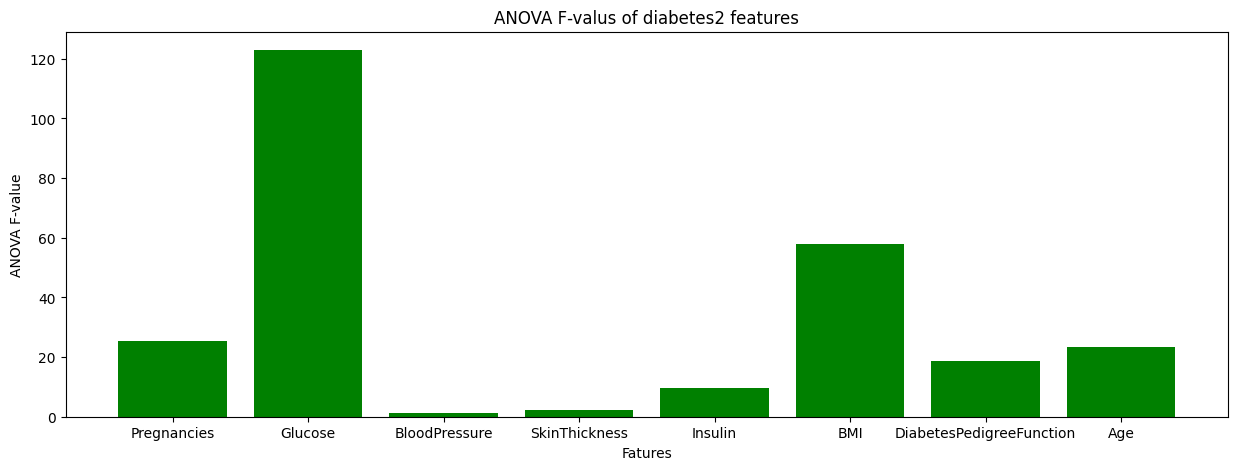

In [ ]:
f, a = f_classif(X_train, Y_train)

labels_diabetes = list(diabetes.columns[:-1])
x_pos = range(len(f))
plt.figure(figsize=(15,5))
plt.bar(labels_diabetes, f, color='green')
plt.xlabel('Fatures')
plt.ylabel('ANOVA F-value')
plt.title('ANOVA F-valus of diabetes2 features')

plt.xticks(x_pos, labels_diabetes)

plt.show()


**TODO: Analyze the results**

1. Give the two most important features according to ANOVA.
1. Why they are considered important? In this case, explain the reasoning behind ANOVA F-value.
1. Why ANOVA was used instead of Pearson?

**Answer**

1. The two most important features according to ANOVA are Glucose and BMI, as they have the highest F-values: large variation between groups → so the groups are significantly different, so these 2 features are important than the others
1. The f-value in anova is a statistical test that measures how much variation exists between groups compared to the variation within groups. It helps determine whether the means of different groups are significantly different. and from reasoning, **Glucose and BMI** are important because their mean values differ significantly between diabetic and non-diabetic groups. so these high f values confirm that these features effectively distinguish between the two groups.
1.
Pearson correlation coefficient is used to measure the strength and direction of the linear relationship between two continuous variables, while ANOVA is used to test for differences in means among two or more groups. [We found this interesting answer in a forum](https://www.quora.com/What-is-the-relationship-between-Pearson-and-ANOVA-in-data-analysis). Since our target variable (Outcome) is to classify (0 or 1), ANOVA is more appropriate for identifying which numerical features best separate the two classes.



#### II.2.2. Filtering and fitting/generalization

Here, we will use to select feeatures with 50% variance.
We want to compare two models: one trained on all features and another only on the most important ones according to ANOVA F-value.
F1-score is used to judge both fitting and generalization.


In [ ]:
selector    = SelectPercentile(score_func=f_classif, percentile=50)
X_train_new = selector.fit_transform(X_train, Y_train)
X_test_new  = selector.transform(X_test)

lreg_anova = LogisticRegression(penalty=None, solver='saga', max_iter=1, warm_start=True, random_state=0)
init_params(lreg_anova, N=X_train_new.shape[1])

history['F1_test' ]['lreg_anova'] = []
history['F1_train']['lreg_anova'] = []
history['Theta'   ]['lreg_anova'] = []

for it in ITLST:
    lreg_anova.fit(X_train_new, Y_train)
    coef = [lreg_anova.intercept_[0]]
    coef.extend(lreg_anova.coef_.flatten().tolist())
    history['Theta'   ]['lreg_anova'].append(coef)
    history['F1_test' ]['lreg_anova'].append(f1_score(Y_test, lreg_anova.predict(X_test_new)))
    history['F1_train']['lreg_anova'].append(f1_score(Y_train, lreg_anova.predict(X_train_new)))


history['Theta']['lreg_anova'] = np.array(history['Theta']['lreg_anova'])


# This is just to check the last time this was executed
# because the next cells depend on the results of this one
now = datetime.datetime.now()
print(now.strftime("%Y-%m-%d %H:%M:%S"))

2025-03-08 22:12:05


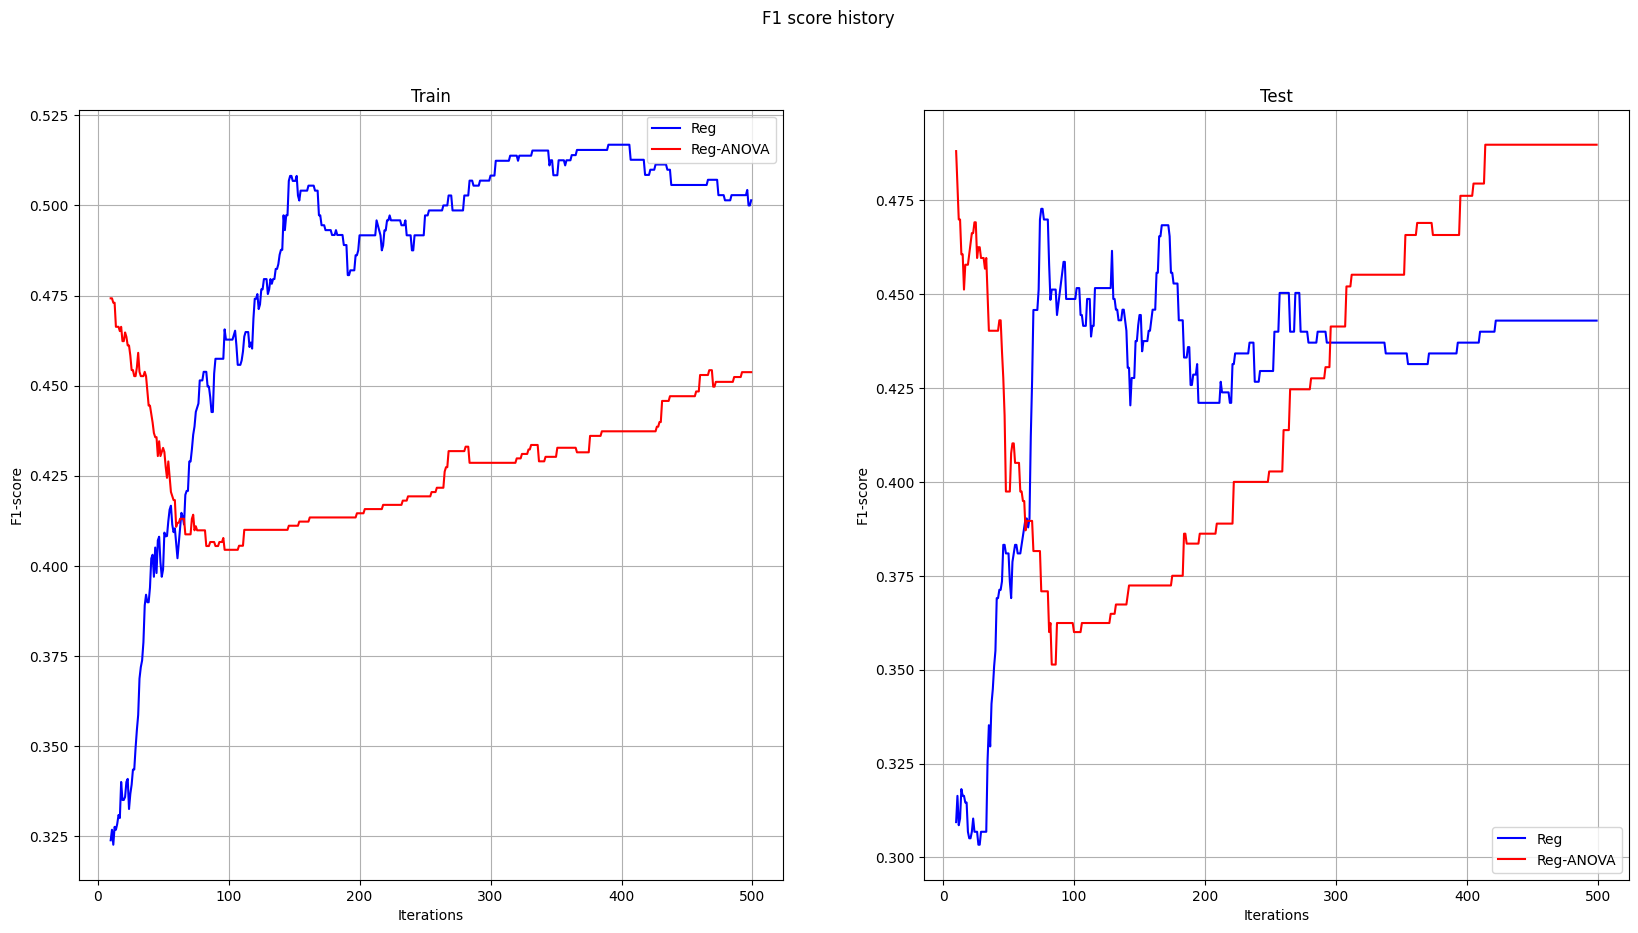

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('F1 score history')
fig.set_figwidth(20)
fig.set_figheight(10)

ax1.plot(ITLST[10:], history['F1_train' ]['00'        ][10:], color='blue', label='Reg'      )
ax1.plot(ITLST[10:], history['F1_train' ]['lreg_anova'][10:], color='red' , label='Reg-ANOVA')
ax2.plot(ITLST[10:], history['F1_test'  ]['00'        ][10:], color='blue', label='Reg'      )
ax2.plot(ITLST[10:], history['F1_test'  ]['lreg_anova'][10:], color='red' , label='Reg-ANOVA')

ax1.set_xlabel('Iterations')
ax1.set_ylabel('F1-score')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('F1-score')

ax1.legend()
ax2.legend()
ax1.set_title('Train')
ax2.set_title('Test')
ax1.grid()
ax2.grid()

plt.show()

**TODO: Analyze the results**

1. Based on train graph, logistic regression without filtering fits quickly and perfectly. Why filtering features decreases fitting capacity either speeed or prformance?
1. Based on test graph, logistic regression without filtering generalizes quickly with less performance. On the other hand, filtering features generalizes slowly with an increasing performance. Why?
1. **Can** filtering prevent overfitting with more iterations? If so, how? If not, why?
1. **Can** filtering prevent underfitting with less iterations? If so, how? If not, why?

**Answer**

1. Filtering removes less relevant features (anova does it), the model has fewer features to learn from and not much information (especially if we keep only the 2 most important features only), hence slower convergence and lower performance in training.
1. Filtering eliminates noisy and irrelevant features, it helps the model gradually learn better patterns, leading to slower generalization but improved performance over more iterations.
1. Yes, by reducing noise and focusing on meaningful features that are perfect to generalize, thus more stable learning across iterations.
1. No, because underfitting happens when the model is too simple to learn meaningful patterns, and removing too many features can make the model too simple, so we get slower learning and poor initial performance.

#### II.2.3. Feature selection comparison

We want to compare different feature selection methods:
- **ANOVA**: Filter based feature selection. We selected 4 features.
- **L1**: Embdded feature selection.
- **FFS (Forward Features Selection)**: Wrapper feature selection. It starts by testing one feature, then adding others till reaching the desired features' number. We selected 4 features.
- **BFE (Backward Features Elimination)**: Wrapper feature selection. It starts by testing all features, then deleting one by one till reaching the desired features' number. We selected 4 features.

The generated models using these 4 methods are evaluated using the following criteria:
- **F1 train**: to answer the question '*how much a model can converge to its global solution?*'
- **F1 test**: to answer the question '*how much a model can generalize on unseen data?*'
- **Iterations number**: to answer the question '*how much iterations are enough to converge?*'
- **Pre-train time**: to answer the question '*how much time data takes to be prepared for processing?*'
- **Train time**: to answer the question '*how much time a model takes to be trained?*'

*P.S. Execution takes time; be patient till you die of boredom*


In [ ]:
CMAX_ITER = 5000
clreg_000  = LogisticRegression(penalty=None, solver='saga', max_iter=CMAX_ITER)
clreg_l1l  = LogisticRegression(penalty='l1', solver='saga', max_iter=CMAX_ITER)
clreg_anv  = LogisticRegression(penalty=None, solver='saga', max_iter=CMAX_ITER)
clreg_ffs  = LogisticRegression(penalty=None, solver='saga', max_iter=CMAX_ITER)
clreg_bfe  = LogisticRegression(penalty=None, solver='saga', max_iter=CMAX_ITER)

time_pp = {}
time_tr = {}

# Normal Logistic Rgression
# ==============================
start_time = timeit.default_timer()
clreg_000.fit(X_train, Y_train)
time_tr['reg'] = timeit.default_timer() - start_time
# ===============================


# L1 Logistic Rgression
# ===============================
start_time = timeit.default_timer()
clreg_l1l.fit(X_train, Y_train)
time_tr['l1'] = timeit.default_timer() - start_time
# ===============================

# Normal Logistic Rgression
# using ANOVA selected features
# ===============================
# Features selection before training
selector_anova = SelectPercentile(score_func=f_classif, percentile=50)
start_time = timeit.default_timer()
X_train_anova = selector_anova.fit_transform(X_train, Y_train)
time_pp['anova'] = timeit.default_timer() - start_time
X_test_anova = selector_anova.transform(X_test)
# Training on selected features
start_time = timeit.default_timer()
clreg_anv.fit(X_train_anova, Y_train)
time_tr['anova'] = timeit.default_timer() - start_time
# ===============================

# Logistic Rgression
# using FFS selected features
# ===============================
# Features selection before training
start_time = timeit.default_timer()
selecteur_ffs = SequentialFeatureSelector(clreg_ffs, n_features_to_select=4, direction='forward')
X_train_ffs = selecteur_ffs.fit_transform(X_train, Y_train)
time_pp['ffs'] = timeit.default_timer() - start_time
X_test_ffs = selecteur_ffs.transform(X_test)
# Training on selected features
start_time = timeit.default_timer()
clreg_ffs.fit(X_train_ffs, Y_train)
time_tr['ffs'] = timeit.default_timer() - start_time
# ===============================

# Logistic Rgression
# using BFE selected features
# ===============================
# Features selection before training
start_time = timeit.default_timer()
selecteur_bfe = SequentialFeatureSelector(clreg_bfe, n_features_to_select=4, direction='backward')
X_train_bfe = selecteur_bfe.fit_transform(X_train, Y_train)
time_pp['bfe'] = timeit.default_timer() - start_time
X_test_bfe = selecteur_bfe.transform(X_test)
# Training on selected features
start_time = timeit.default_timer()
clreg_bfe.fit(X_train_bfe, Y_train)
time_tr['bfe'] = timeit.default_timer() - start_time
# ===============================

pd.DataFrame({
    'Criteria' : ['F1 Train',
                  'F1 Test',
                  'Iterations',
                  'Pre-train time',
                  'Train time'],
    'Reg'      : [f1_score(Y_train, clreg_000.predict(X_train)),
                  f1_score(Y_test, clreg_000.predict(X_test)),
                  clreg_000.n_iter_,
                  0,
                  time_tr['reg']],
    'Reg+L1'   : [f1_score(Y_train, clreg_l1l.predict(X_train)),
                  f1_score(Y_test, clreg_l1l.predict(X_test)),
                  clreg_l1l.n_iter_,
                  0,
                  time_tr['l1']],
    'ANOVA+Reg': [f1_score(Y_train, clreg_anv.predict(X_train_anova)),
                  f1_score(Y_test, clreg_anv.predict(X_test_anova)),
                  clreg_anv.n_iter_,
                  time_pp['anova'],
                  time_tr['anova']],
    'FFS'      : [f1_score(Y_train, clreg_ffs.predict(X_train_ffs)),
                  f1_score(Y_test, clreg_ffs.predict(X_test_ffs)),
                  clreg_ffs.n_iter_,
                  time_pp['ffs'],
                  time_tr['ffs']],
    'BFE'      : [f1_score(Y_train, clreg_bfe.predict(X_train_bfe)),
                  f1_score(Y_test, clreg_bfe.predict(X_test_bfe)),
                  clreg_bfe.n_iter_,
                  time_pp['bfe'],
                  time_tr['bfe']],
})

,Criteria,Reg,Reg+L1,ANOVA+Reg,FFS,BFE
0,F1 Train,0.465574,0.465574,0.379928,0.567568,0.585526
1,F1 Test,0.380165,0.380165,0.37931,0.564516,0.539683
2,Iterations,[1407],[1404],[156],[5000],[5000]
3,Pre-train time,0,0,0.001769,17.341908,37.543407
4,Train time,0.153231,0.186401,0.012043,0.364515,0.340454


**TODO: Analyze the results**

1. Why L1-based model takes more time to train than the one using normal one although it takes less iterations?
1. Why L1-based model takes less iterations to converge than normal one?
1. We've seen in the past experiment that ANOVA can generalize better. But, in here it is not as good as normal regression. Why?
1. Why wrapper-based models take more time to train than the normal one although they use less features?
1. Why wrapper-based models give better performance (fitting and generalization) than filter based (ANOVA) one?
1. What can we conclude when we see that wrapper-based models reach the maximum iterations?
1. When FFS pretrain time is better than that of BFE and the inverse?

**Answer**

1. L1-based model takes more time to train than normal regression because L1 regularization introduces sparsity aka additional computation to update feature weights selectively.
1. L1-based model converges in fewer iterations than normal regression because L1 regularization forces some weights to zero, the model quickly identifies and discards irrelevant coefficients, and hence faster convergence.
1. ANOVA selects features independently of the model. While it ensures statistical relevance, it may not always align with the best feature set for the specific learning algorithm. A feature with a high individual F-score may not necessarily contribute to better predictions when combined with others.
1. Wrapper-based models take more time to train than normal regression because they iteratively test multiple feature subsets, and several model evaluations before selecting the final feature set(the last 4).
1. Wrapper-based models outperform anova because they select features based on actual model performance, whereas the latter rely only on statistical tests that do not account for interactions between features(as we've noticed in the weak F1 score by anova).
1. They took a lot of time to converge (maybe because of iterations)
1. FFS has a better pretrain time than BFE when the number of initial candidate features is large, since FFS starts small and adds features, whereas BFE begins with all features and iteratively removes them.

In [ ]:
print('This lab is finished, and all ML\'s suffering with it')

This lab is finished, and all ML's suffering with it
